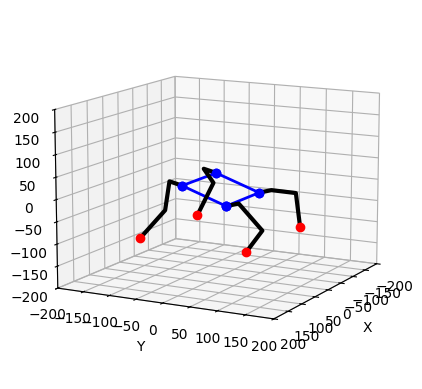

In [1]:
from mpl_toolkits import mplot3d
import numpy as np
from math import *
import matplotlib.pyplot as plt

def setupView(limit,fig=None):
    if fig is None:
        ax = plt.axes(projection="3d")
    else:
        ax = fig.add_subplot(111, projection='3d')
    ax.set_xlim(-limit, limit)
    ax.set_ylim(-limit, limit)
    ax.set_zlim(-limit, limit)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    return ax

%matplotlib inline
setupView(200).view_init(elev=12., azim=28)

l1=25
l2=0
l3=80
l4=80

L = 120
W = 90

Lp=np.array([[100,-100,100,1],[100,-100,-100,1],[-100,-100,100,1],[-100,-100,-100,1]])

sHp=np.sin(pi/2)
cHp=np.cos(pi/2)

Lo=np.array([0,0,0,1])

def bodyIK(omega,phi,psi,xm,ym,zm):
    Rx = np.array([[1,0,0,0],
                   [0,np.cos(omega),-np.sin(omega),0],
                   [0,np.sin(omega),np.cos(omega),0],[0,0,0,1]])
    Ry = np.array([[np.cos(phi),0,np.sin(phi),0],
                   [0,1,0,0],
                   [-np.sin(phi),0,np.cos(phi),0],[0,0,0,1]])
    Rz = np.array([[np.cos(psi),-np.sin(psi),0,0],
                   [np.sin(psi),np.cos(psi),0,0],[0,0,1,0],[0,0,0,1]])
    Rxyz=Rx@Ry@Rz

    T = np.array([[0,0,0,xm],[0,0,0,ym],[0,0,0,zm],[0,0,0,0]])
    Tm = T+Rxyz

    return([Tm @ np.array([[cHp,0,sHp,L/2],[0,1,0,0],[-sHp,0,cHp,W/2],[0,0,0,1]]),
           Tm @ np.array([[cHp,0,sHp,L/2],[0,1,0,0],[-sHp,0,cHp,-W/2],[0,0,0,1]]),
           Tm @ np.array([[cHp,0,sHp,-L/2],[0,1,0,0],[-sHp,0,cHp,W/2],[0,0,0,1]]),
           Tm @ np.array([[cHp,0,sHp,-L/2],[0,1,0,0],[-sHp,0,cHp,-W/2],[0,0,0,1]])
           ])

def legIK(point):
    (x,y,z)=(point[0],point[1],point[2])
    F=sqrt(x**2+y**2-l1**2)
    G=F-l2  
    H=sqrt(G**2+z**2)
    theta1=-atan2(y,x)-atan2(F,-l1)

    D=(H**2-l3**2-l4**2)/(2*l3*l4)
    theta3=acos(D) 

    theta2=atan2(z,G)-atan2(l4*sin(theta3),l3+l4*cos(theta3))

    return(theta1,theta2,theta3)

def calcLegPoints(angles):
    (theta1,theta2,theta3)=angles
    theta23=theta2+theta3

    T0=Lo
    T1=T0+np.array([-l1*cos(theta1),l1*sin(theta1),0,0])
    T2=T1+np.array([-l2*sin(theta1),-l2*cos(theta1),0,0])
    T3=T2+np.array([-l3*sin(theta1)*cos(theta2),-l3*cos(theta1)*cos(theta2),l3*sin(theta2),0])
    T4=T3+np.array([-l4*sin(theta1)*cos(theta23),-l4*cos(theta1)*cos(theta23),l4*sin(theta23),0])

    return np.array([T0,T1,T2,T3,T4])

def drawLegPoints(p):
    plt.plot([x[0] for x in p],[x[2] for x in p],[x[1] for x in p], 'k-', lw=3)
    plt.plot([p[0][0]],[p[0][2]],[p[0][1]],'bo',lw=2)
    plt.plot([p[4][0]],[p[4][2]],[p[4][1]],'ro',lw=2)    

def drawLegPair(Tl,Tr,Ll,Lr):
    Ix=np.array([[-1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]])
    drawLegPoints([Tl@x for x in calcLegPoints(legIK(np.linalg.inv(Tl)@Ll))])
    drawLegPoints([Tr@Ix@x for x in calcLegPoints(legIK(Ix@np.linalg.inv(Tr)@Lr))])

def drawRobot(Lp,angles,center):
    (omega,phi,psi)=angles
    (xm,ym,zm)=center

    FP=[0,0,0,1]
    try:
        (Tlf,Trf,Tlb,Trb)= bodyIK(omega,phi,psi,xm,ym,zm)
        CP=[x@FP for x in [Tlf,Trf,Tlb,Trb]]
    except ValueError:
        print("IK Error: check body angles/position")
        return

    CPs=[CP[x] for x in [0,1,3,2,0]]
    plt.plot([x[0] for x in CPs],[x[2] for x in CPs],[x[1] for x in CPs], 'bo-', lw=2)

    try:
        drawLegPair(Tlf,Trf,Lp[0],Lp[1])
        drawLegPair(Tlb,Trb,Lp[2],Lp[3])
    except ValueError:
        print("IK Error: check leg lengths/positions")
        return

drawRobot(Lp,(0.4,0,0),(0,0,0))

In [9]:
from ipywidgets import interact, FloatSlider

def lev(X,Y,m1,m2):
    return X*m1 + Y*m2 - 100


# Create a function to update the plot based on a slider value
def update_plot(m1,m2):
    fig = plt.figure(figsize=(16, 10))
    ax = setupView(200,fig)
    ax.view_init(elev=12., azim=28)
    x = np.linspace(-200, 200, 4**2)
    y = np.linspace(-200, 200, 4**2)
    X, Y = np.meshgrid(x, y)
    Z = lev(X,Y,m1,m2)
    Lp=np.array([[100,lev(100,100,m1,m2),100,1],[100,lev(100,-100,m1,m2),-100,1],[-100,lev(-100,100,m1,m2),100,1],[-100,lev(-100,-100,m1,m2),-100,1]])
    drawRobot(Lp,(0,0,0),(0,0,0))
    ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.6)
    plt.close(fig) # Prevent duplicate figures in Jupyter
    return fig

# Create an interactive slider
multiplier_slider1 = FloatSlider(min=-.3, max=.3, step=0.01, description='Multiplier1:')
multiplier_slider2 = FloatSlider(min=-.3, max=.3, step=0.01, description='Multiplier2:')

# Link the slider to the update function
interact(update_plot, m1=multiplier_slider1,m2=multiplier_slider2)

interactive(children=(FloatSlider(value=0.0, description='Multiplier1:', max=0.3, min=-0.3, step=0.01), FloatS…

<function __main__.update_plot(m1, m2)>